In [4]:
ls

README.md                         get_one_element_images.ipynb
confocal_data/                    tri_color_elemental_distribution/


In [15]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import math, re, os
from imageio import imwrite

def _natural_key(s):
    return [int(t) if t.isdigit() else t for t in re.split(r"(\d+)", s)]

def plot_confocal_stack(folder, element="ZnKa_Sum", pattern="*.hdf5", out_format=".tiff"):
    folder = Path(folder)
    files = sorted([str(p) for p in folder.glob(pattern)], key=_natural_key)
    if not files:
        raise FileNotFoundError(f"No files match {pattern} in {folder}")

    maps, extents, titles = [], [], []
    elem_idx = None
    i0_idx = None

    for fp in files:
        with h5py.File(fp, "r") as f:
            det = f["2D Scan/Detectors"]
            Xds = f["2D Scan/X Positions"]
            Yds = f["2D Scan/Y Positions"]

            if elem_idx is None or i0_idx is None:
                names = [n.decode() if hasattr(n, "decode") else str(n)
                         for n in det.attrs["Detector Names"]]
                # element index
                if element in names:
                    elem_idx = names.index(element)
                else:
                    cand = [i for i, n in enumerate(names)
                            if element.lower().replace("_","") in n.lower().replace("_","")]
                    if not cand:
                        raise KeyError(f"Element '{element}' not found in detectors: {names}")
                    elem_idx = cand[0]
                # I0 index
                if "I0" in names:
                    i0_idx = names.index("I0")
                else:
                    raise KeyError("Detector 'I0' not found.")

            signal = det[:, :, elem_idx].astype(float)
            i0 = det[:, :, i0_idx].astype(float)

            with np.errstate(divide="ignore", invalid="ignore"):
                norm = np.where(i0 > 0, signal / i0, np.nan)

            X = Xds[:, :, 0]
            Y = Yds[0, :]
            extent = [np.nanmin(X), np.nanmax(X), np.nanmin(Y), np.nanmax(Y)]

            maps.append(norm)
            extents.append(extent)
            titles.append(Path(fp).stem)  # use stem for filenames

    # pad to common shape
    ny_max = max(m.shape[0] for m in maps)
    nx_max = max(m.shape[1] for m in maps)
    stack = np.full((len(maps), ny_max, nx_max), np.nan, float)
    for i, m in enumerate(maps):
        ny, nx = m.shape
        stack[i, :ny, :nx] = m

    # plot
    n = stack.shape[0]
    cols = min(3, n)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = np.atleast_1d(axes).ravel()

    for i, ax in enumerate(axes):
        if i >= n:
            ax.set_visible(False); continue
        ny, nx = maps[i].shape
        ax.imshow(stack[i, :ny, :nx], origin="lower", extent=extents[i], aspect="auto")
        ax.set_title(titles[i], fontsize=9)
        ax.set_xlabel("X position")
        ax.set_ylabel("Y position")

    fig.suptitle(f"{element} / I0 maps", fontsize=12)
    fig.tight_layout()
    plt.show()

    # --- export ---
    if out_format:
        out_dir = folder / f"{element}_exported"
        out_dir.mkdir(exist_ok=True)
        for i, arr in enumerate(maps):
            out_path = out_dir / f"{titles[i]}{out_format}"
            # scale to 16-bit for saving
            arr_norm = arr / np.nanmax(arr) if np.nanmax(arr) > 0 else arr
            arr_uint16 = np.nan_to_num(arr_norm * 65535).astype(np.uint16)
            imwrite(out_path, arr_uint16)
        print(f"Exported {len(maps)} images to {out_dir}")

    return {
        "stack": stack,
        "files": files,
        "extents": extents,
        "titles": titles,
        "element_index": elem_idx,
        "i0_index": i0_idx,
    }

# Export certain elemental maps into individual images

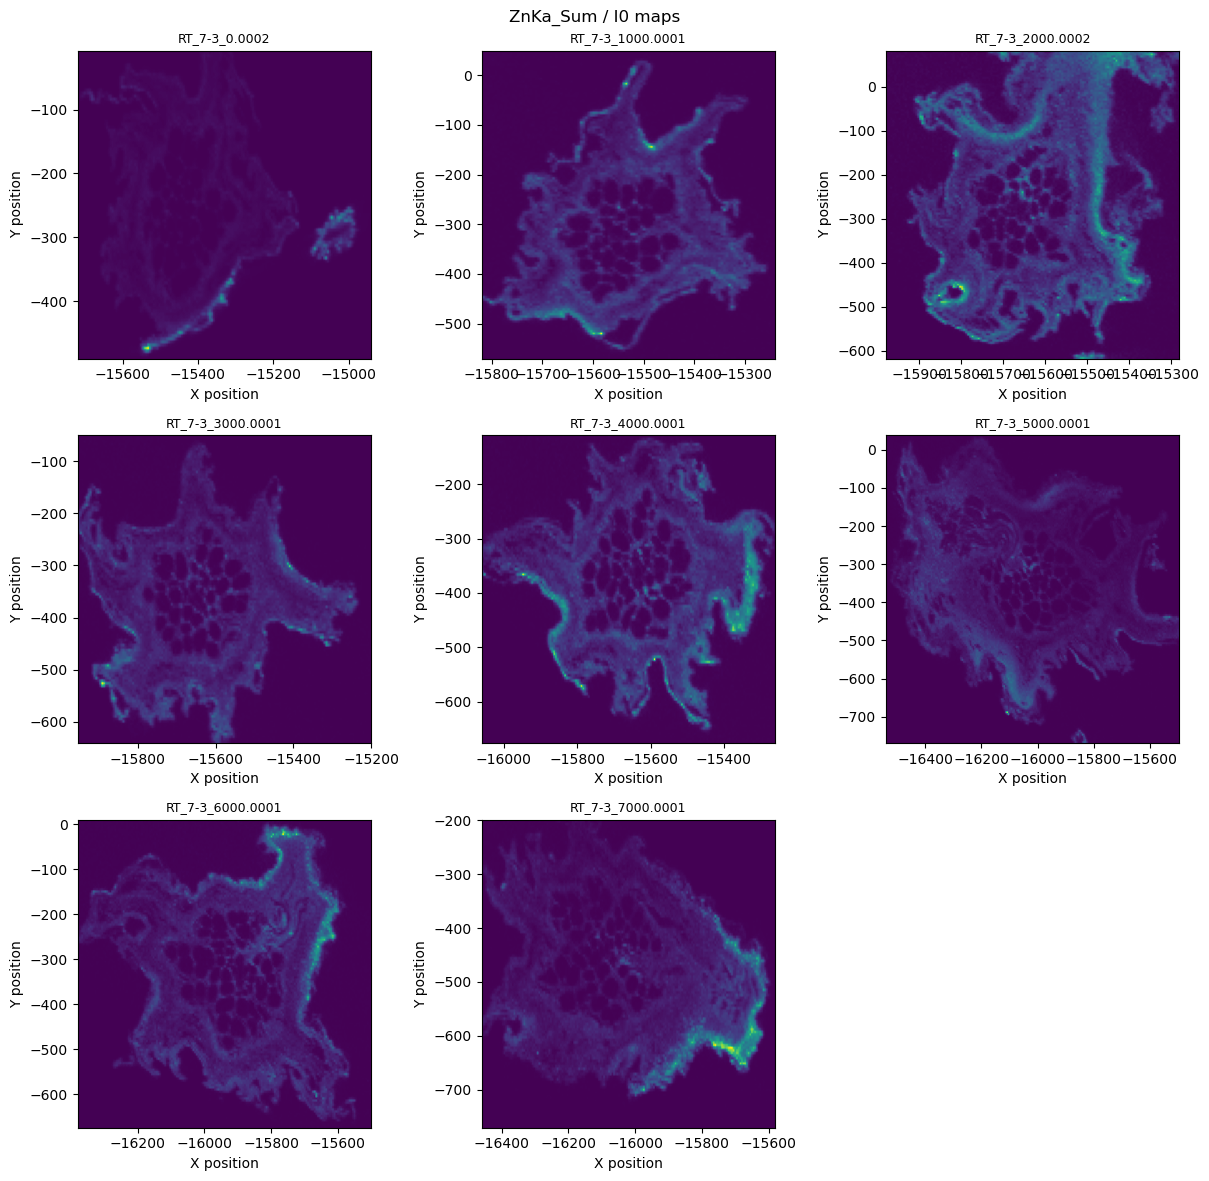

Exported 8 images to confocal_data/root_mature/ZnKa_Sum_exported


In [16]:
out = plot_confocal_stack(folder="confocal_data/root_mature", 
                          element="ZnKa_Sum", 
                          out_format=".tiff")

/var/folders/5h/bwjv61nx557b84_9jl_lkh540000gn/T/ipykernel_3142/2505449380.py:78: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.imshow(stack[i, :ny, :nx], origin="lower", extent=extents[i], aspect="auto")


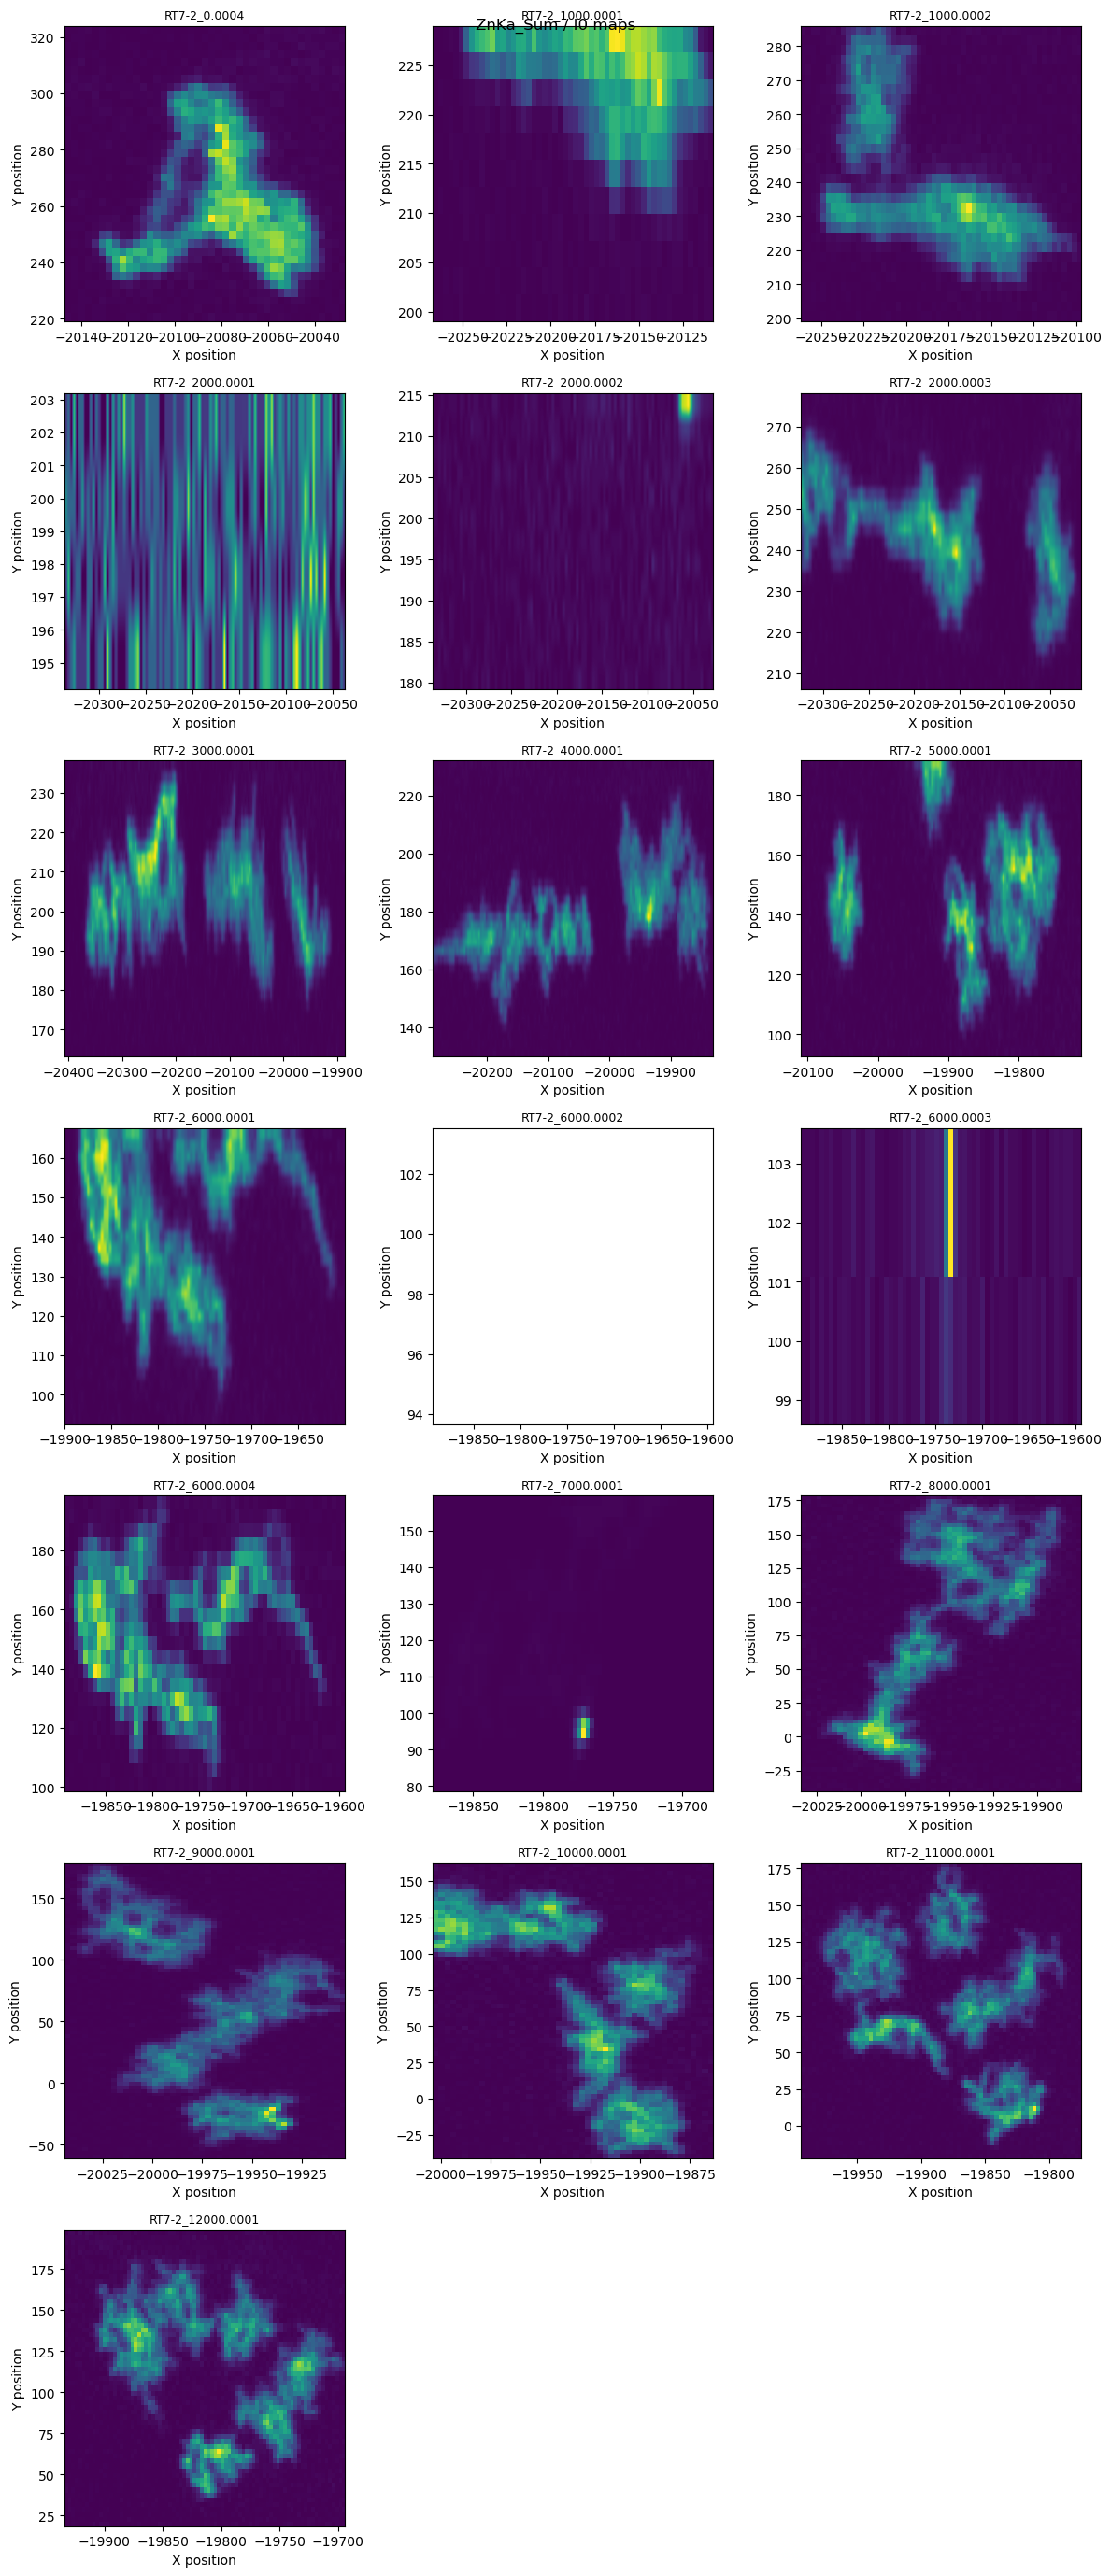

Exported 19 images to confocal_data/root_middle/ZnKa_Sum_exported


In [17]:
out = plot_confocal_stack(folder="confocal_data/root_middle", 
                          element="ZnKa_Sum", 
                          out_format=".tiff")

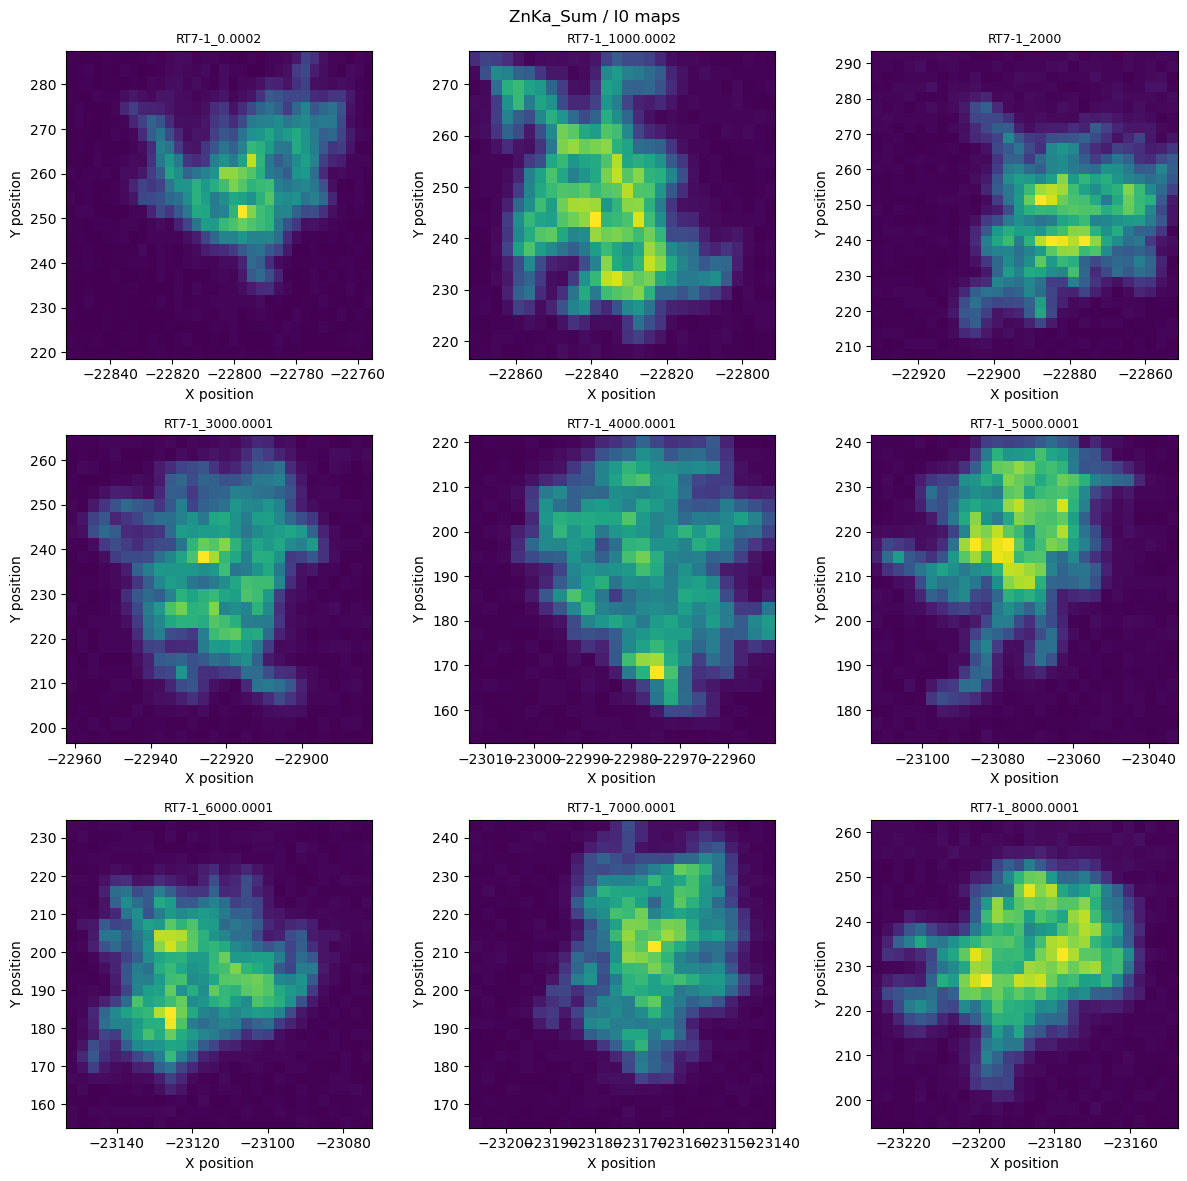

Exported 9 images to confocal_data/root_tip/ZnKa_Sum_exported


In [18]:
out = plot_confocal_stack(folder="confocal_data/root_tip", 
                          element="ZnKa_Sum", 
                          out_format=".tiff")